# AI-matchmaker: Algorithmic Sexism

---

### Introduction

Automation has been key to Amazon's dominance, be it inside logistics, marketing or driving pricing decisions. In 2014 Amazon started working on building an Artificial Intelligence (AI) tool to help hiring candidates. In order to search for top talent, the team of Amazon built a computer program which review a job applicant's resume on a scale from one to five stars. The idea was simple: we give the algorithm 100 resumes as input and it will spit out the top five and we will hire those candidates. 

By 2015, however, the engineers noticed that the program was not treating candidates in a gender-neutral way.
In the beginning of 2017 the project was reportedly abandoned after executives lost faith in it. Although the company claims it never actually used the algorithm to evaluate candidates, it offers a case study where the risks of Artificial Intelligence (AI) are painfully exposed.

Last years there has been a burst in awareness for the need to create responsible AI. That is, AI that can be understood and explained, is fair and acceptable. As responsible AI is one the hottest topics in machine learning, more and more tools are becoming available that can, for example, help us create fair algorithms from biased data. <br> <br>
At VIQTOR DAVIS we encounter many datasets from numerous different business cases. As data scientists using machine learning and artificial intelligence on a daily basis, dataset bias is an issue that we need to tackle in (almost) every project.
Based on our experience and expertise we have developed a standardized approach to measure and mitigate fairness in AI solutions. 

As part of this framework we wrote this article, where we provide an example of our experience dealing with unfairness in AI. Specifically, we present a case study where an unfair model can arise from a (seemingly harmless) inequality that exists in contemporary society. In this case study the following questions will be addressed:
- How can we detect unfair models?
- How can we quantify the unfairness?
- How can we overcome the problem of unfairness?
<br> <br>

_Disclaimer: <br>
The case study presented in this article is purely hypothetical and the used dataset was artificially constructed to serve the purposes of this project._

 <br>

### Case study

Imagine we are founders of some hypothetical Data Science company, who experienced an immense growth over the last years. 
To keep up with this growth, five full time recruiters were employed, spending a lot of time scanning CV's whether a candidate is suitable to work as a Data Scientist. 
Given the high recruitment costs and the fear for human biases, we plan to use data and algorithms to automate the HR recruitment process. 
We will train a recruitment bot, which can than take a resume, extract all relevant information, and spit out a score  based on his/her competences.
This provides a shortlist of suitable candidates and helps us decide whether to invite a candidate or not. 
To train the model we need to gather a lot of data, since the model needs to be "fed" with all kinds of input to capture as much information as possible.


In order to do so we gathered the resumes of 3,000 students who graduated last year. To train the model well, we ensured the training data consisted of resumes of students with different backgrounds and competences. 
Say that we manually assigned a score to each resume fully based on competences. We simply asked our recruiters to what degree they think the student is suitable for being a data scientist. Our recruiters mainly look at the studyfield being relevant and whether the students speaks english fluently. Also, the student has an edge when having high grades. When each candidate is manually scored by the recruiters, this score is used to label whether the candiate is considered suitable or not. 
If the candidate is considered suitable he/she will be invited for an interview. This denotes the target variable for this case study.

The goal of this article is to show how it is possible for an algorithm to become unfair if a certain group has more suitable candidates than the other group. 
In this case we are aiming for students with a quantitative background. 
And that's where the discrepancy comes in. <br>
We must realise good candidates (i.e. students with a quantitative background) are not equally dispersed among protected groups. 
In the Netherlands we find that men are overrepresented in technical studies, while women are more likely to choose a social study. 
For example, 80% of the science students at the UvA is male, while only 30% of the Psychology students consist of men (www.uva.nl).


##### Import requirements
As with many Python projects we start with importing the necessary packages. Next to the packages that all you data scientists already know and love, we will also use two packages in order to assess fairness and evaluate models:
- Aequitas: a flexible bias-audit utility for algorithmic decision-making models. We will use it to evaluate model performance across several bias and fairness metrics.
- Aif360: fairness toolkit, which provides algorithms to mititage bias in datasets and algorithms.

In [1]:
import pandas as pd 
import numpy as np 
import statsmodels.api as sm
import random
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(31)

##### Dataset simulation

_Disclaimer: the dataset for this case study is artificially created and is supposed to reflect a random group of graduated students from a university in the Netherlands. Gender disparity among studies are based on numbers of the university of Amsterdam. We took these numbers from www.uva.nl, where the ratio male - female is provided for each study._

<br>

As the code for the dataset simulation is relatively long, the dataset is loaded into memory directly. The code for the dataset simulation will be included in the Appendix. The following variables are included:
- Gender
- Studyfield
- Education
- Ethnicity
- Exchange
- Highschool
- Nationality
- Grade
- English


Since we want to be fair, the variables 'Education', 'Studyfield', 'Grade' and 'English' determine the probability to be selected by a recruiter. This means each individual $i$ has a probability $p_{i}$ to be invited for an interview. These probabilities are used within a Bernoulli distribution, $B(1,p_{i})$, to construct the target variable $y_{i} \in \{0,1\}$. This means we draw from 3,000 different Bernoulli distributions, where the parameter $p_{i}$ differs among candidates. As the target variable denotes whether the candidate was selected by the recruiter, this setup ensures students with poor profiles can still be selected, while students with suiting profiles can be neglected.

As our recruiters mainly focus on competences, the variable studyfield is a good predictor when determining whether the candidate is suitable. And here comes the point: there are simply more male candidates fitting this profile then female ones. 
This societal discrepancy is something we can't change in the data. 
But we need to be aware the model correctly learns from the education component and not inadvertently learns that sex itself determines whether we should invite a candidate for an interview or not. Especially when these (biased) models are involved in decision-making processes (which for example determine access to employment, education, social protection, supply of services) and involve certain protected classes (like gender, race, ethnicity) this requires a cautious approach. The first step in this process is to be aware of the dataset bias we are facing here.
Once we're aware of what we're facing, our next step will be to mitigate the problem.


In [2]:
df = pd.read_csv(r'C:\Users\Jasper Rouschop\Documents\Internal Projects\Project Albatros\Case study - AI Recruiter\student_dataset.csv', index_col = 0)
df.head()

,Gender,Nationality,Education,Age,Highschool,Studyfield,Ethnicity,Exchange,Grade,English,Prob,Target
1006,F,Dutch,Master,25,VWO,Business,Black,No,7.0,C,0.10,0
775,M,Belgium,Bachelor,26,VWO,Math,Black,No,7.0,B,0.30,0
394,F,Dutch,Master,24,VWO,Linguistics,Asian,No,8.5,B,0.05,0
1361,F,Dutch,Master,29,VWO,Business,White,Yes,6.0,B,0.10,0
583,M,Dutch,Master,23,VWO,Business,Asian,No,8.5,B,0.15,0


##### Data exploration
The data is loaded. To get an idea what the data looks like, we will first do some data exploration. We will also investigate how the outcome (a dummy variable whether the candidate was invited) is dispersed with the variables. This allows us to get an idea which variables are most important. An easy way to start is using the 'describe' method, which describes the numeric variables in terms of count, mean, variance and some other percentile metrics. Let's see how this looks for the outcome variable.

In [3]:
df['Target'].describe()

count    3000.000000
mean        0.174333
std         0.379459
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Target, dtype: float64

From this we conclude approximately 17.4% of the candidates was selected for an interview. 

The following countplots demonstrate how categories of the variables in our dataset are dispersed. In this figure all counts of the variables in the dataset are provided. Recall the total number of students is 3,000.

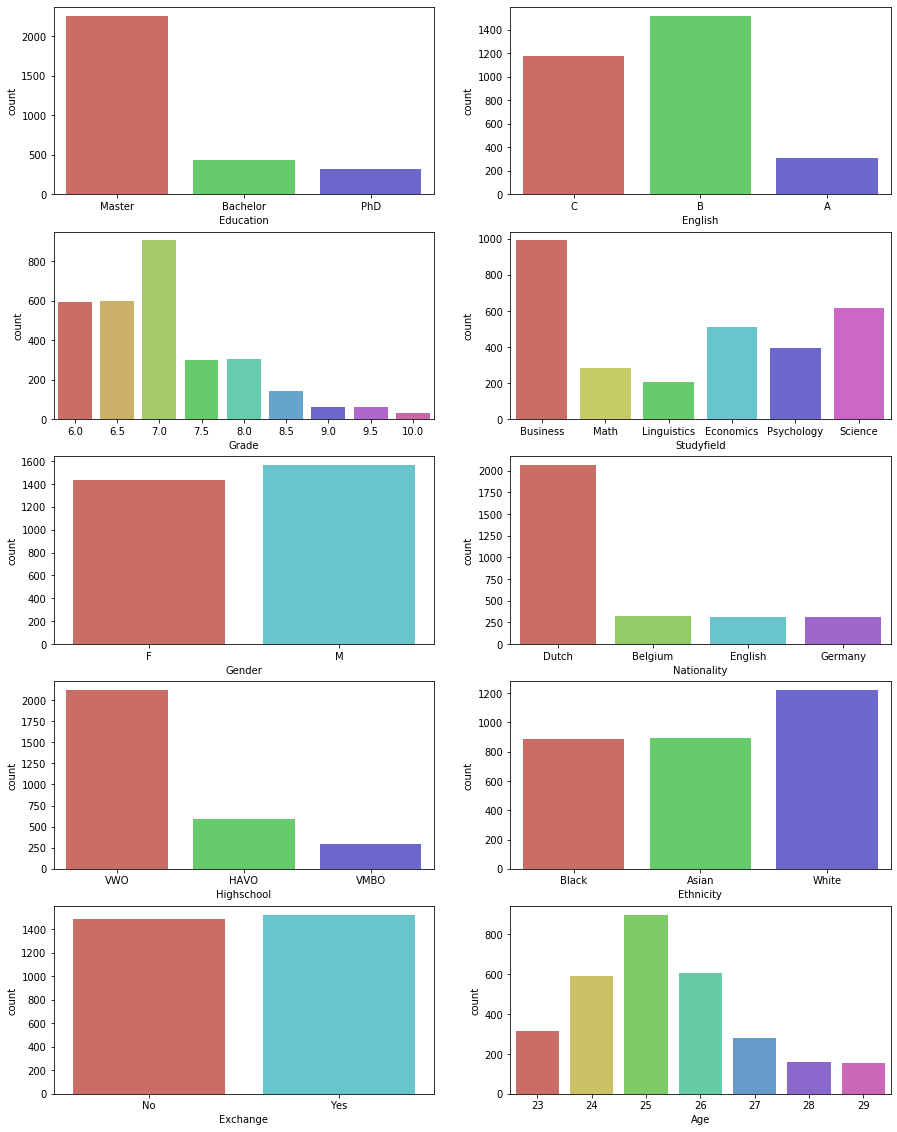

In [4]:
f, axes = plt.subplots(5, 2, figsize=(15, 20))
sns.countplot(x = 'Education', data = df, ax=axes[0, 0], palette = 'hls')
sns.countplot(x = 'Grade', data = df, ax=axes[1, 0], palette = 'hls')
sns.countplot(x = 'English', data = df, ax=axes[0, 1], palette = 'hls')
sns.countplot(x = 'Studyfield', data = df, ax=axes[1, 1], palette = 'hls')
sns.countplot(x = 'Gender', data = df, ax=axes[2, 0], palette = 'hls')
sns.countplot(x = 'Nationality', data = df, ax=axes[2, 1], palette = 'hls')
sns.countplot(x = 'Highschool', data = df, ax=axes[3, 0], palette = 'hls')
sns.countplot(x = 'Ethnicity', data = df, ax=axes[3, 1], palette = 'hls')
sns.countplot(x = 'Exchange', data = df, ax=axes[4, 0], palette = 'hls')
sns.countplot(x = 'Age', data = df, ax=axes[4, 1], palette = 'hls')

Now that we have an idea of the variables there are in our dataset and what values they can attain, we can investigate how they relate with the outcome. To do so, we can simply go through all variables and check whether there are some (visually) outstanding subgroups in terms of invited candidates. 

We will go through all variables one by one and compare the proportion of invited candidates among subgroups. If there are large differences, the variable might be important for predicting whether a candidate suits the job. 

__Nationality:__<br>
Shows the nationality of the student. Considering the countplots, the only notable difference is between Belgian and German candidates.

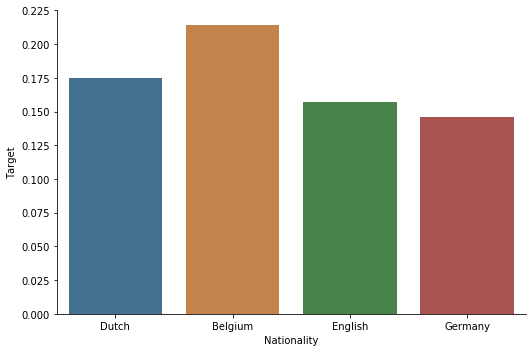

In [5]:
sns.catplot(x="Nationality", y="Target", kind="bar", data=df, ci = None, aspect = 1.5, saturation = 0.5)

__Education:__<br>
Shows the highest level of education the student has finished. 
Clearly this is an important variable for predicting whether the candidate was invited. Apparently, recruiters found Master and PhD students more suitable than students who only finished a Bachelor.

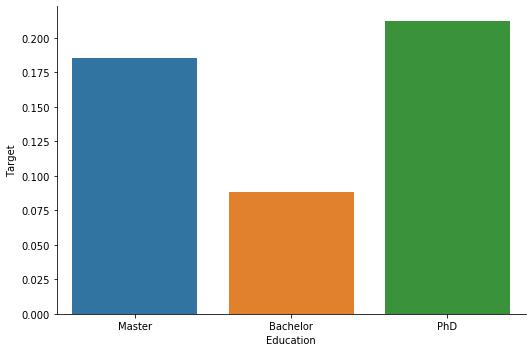

In [6]:
sns.catplot(x="Education", y="Target", kind="bar", data=df, ci = None, aspect = 1.5)

__Age__:<br>
Shows age of the student.
It seems more or less the same amount of candidates are contacted from different ages. Since there are no notable outliers for specific age groups, this variable is probably not that important for predicting the target.

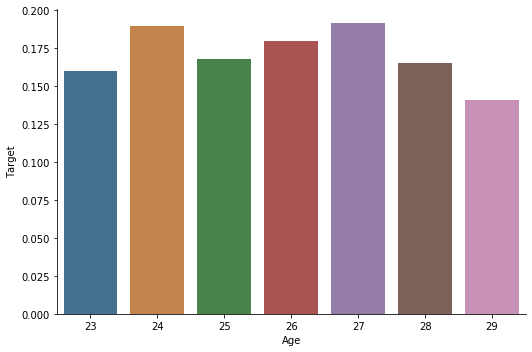

In [7]:
sns.catplot(x="Age", y="Target", kind="bar", data=df, ci = None, aspect = 1.5, saturation = 0.5)

__Highschool:__<br>
Shows the high school degree the student finished. For all you non-dutchies: VWO gives you immediate access to university, while HAVO and VMBO students have to follow an alternative path.
The proportions of invited candidates are distributed the same among high school subgroups. Therefore this variable is probably not that important for predicting the outcome.

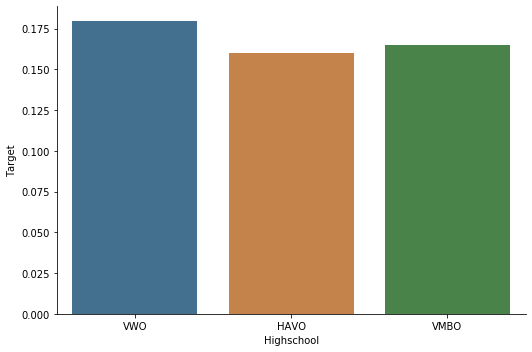

In [8]:
sns.catplot(x="Highschool", y="Target", kind="bar", data=df, ci = None, aspect = 1.5, saturation = 0.5)

__Studyfield:__<br>
Over 30% of the science and math students were considered good candidates and were selected for an interview. The proportion of invited candidates from other studies was around 5% - 10%. As we would expect, this variable is quite important in determining whether a candidate is invited for an interview or not.

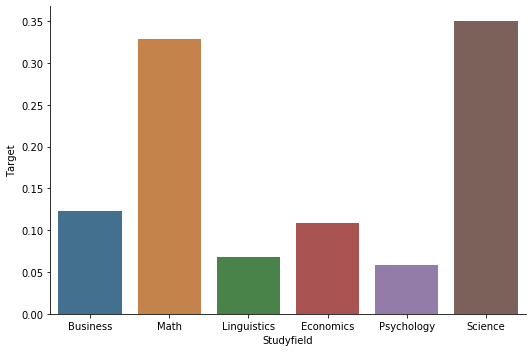

In [9]:
sns.catplot(x="Studyfield", y="Target", kind="bar", data=df, ci = None, aspect = 1.5, saturation = 0.5)

__Exchange:__<br>
This variable describes whether a student went on exchange during his study. Although the difference seems negligible, we invited slightly more students who went on exchange. 

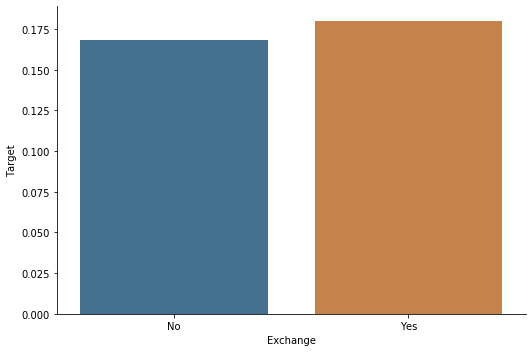

In [10]:
sns.catplot(x="Exchange", y="Target", kind="bar", data=df, ci = None, aspect = 1.5, saturation = 0.5)

__Grade:__<br>
An important variable whether a student was invited for an interview was the grade the student graduated with. Students with high grades (7.5 - 10) were contacted relatively more than students with lower grades (6.0 - 7.0).

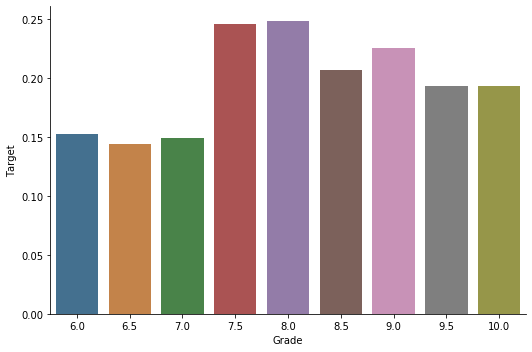

In [11]:
sns.catplot(x="Grade", y="Target", kind="bar", data=df, ci = None, aspect = 1.5, saturation = 0.5)

__English:__<br>
This variable denotes the english proficiency level of the student. As you can see, students with proficiency level B or C were almost 3 times more likely to be contacted than students with proficiency level A. It seems a low english proficiency level was a no-go for the company. 

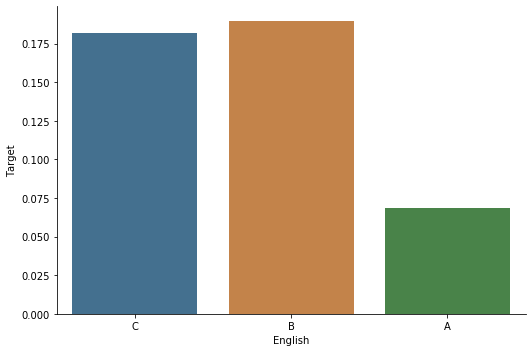

In [12]:
sns.catplot(x="English", y="Target", kind="bar", data=df, ci = None, aspect = 1.5, saturation = 0.5)

So far there are four variables showing great discrepancy in the outcome, meaning they are potentially important for predicting whether a candidate should be selected. These are; English, Studyfield, Education and Grade. It seems reasonable to judge a candidate on these variables. Let's look how the outcome is dispersed with some protected classes like sex and ethnicity.

__Gender:__<br>
Wow! Looking at these graph it looks like gender might be a good predictor when determining whether a candidate is suitable. 
From the male candidates approximately 25% was contacted, while only +/-12% of the female candidates was sent an invite. 

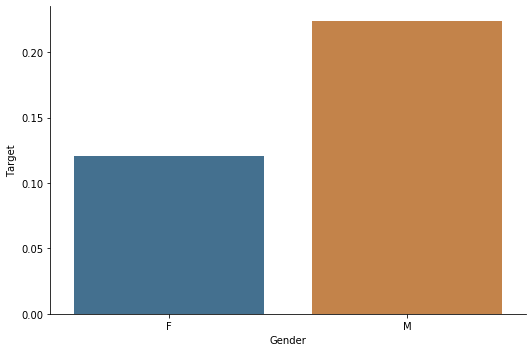

In [13]:
sns.catplot(x="Gender", y="Target", kind="bar", data=df, ci = None, aspect = 1.5, saturation = 0.5)

__Ethnicity:__<br>
Gender seems problematic and we should be really cautious when using this variable in our algorithm. Luckily ethnicity seems fine. It seems (approximately) the same percentage of each ethnicity group was selected. We can worry a bit less asbout this variable!

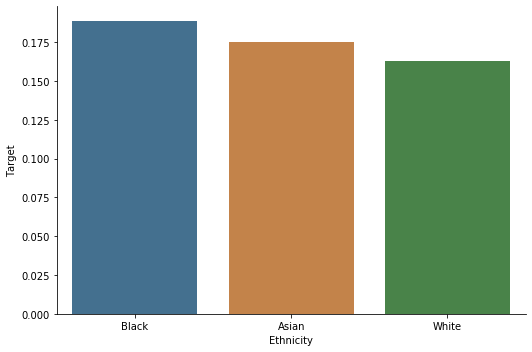

In [14]:
sns.catplot(x="Ethnicity", y="Target", kind="bar", data=df, ci = None, aspect = 1.5, saturation = 0.5)

##### Data Cleaning 
In order to train our AI-matchmaker we will use logistic regression. Logistic regression is a machine learning model that uses a logistic function to model a binary dependent variable. Although there are better models in terms of performance (a.o. boosting methods, random forest, deep neural networks), logistic regression provides coefficients which are very easy to interpret. In the blink of an eye one can see the degree in which a variable contributes to the model. As this is an important feature for demonstration purposes, logistic regression is used here.

Logistic regression requires the predictors to be numerical, so we need to pre-process the categorical variables into numeric dummy variables before applying the model. When dummy-encoding a categorical variable we need to ensure one category is omitted, in order to avoid perfect collinearrity. Let's construct a function to do so!

In [15]:
def dummy_encode(df, cat_vars):
    for var in cat_vars:
        tj = pd.get_dummies(df[var], prefix = var)
        tj.drop(tj.columns[len(tj.columns)-1], axis = 1, inplace = True) # Throw away last column to prevent perfect collinearity
        df = pd.concat([df, tj], axis=1, sort=False)


    columns = df.columns.tolist()
    cols_to_keep = [i for i in columns if i not in cat_vars]
    df = df[cols_to_keep]
    return df

We also need to evaluate our model. Remember, we manually evaluated 3,000 students' resumes to decide whether to invite them for an interview or not.
Now, we are going to use this information to feed our AI-matchmaker and automate the process. Therefore, we also need to validate our model. This requires us to split the features (X) from the target (y) and create a training and test set. We choose 60% of our data to train our model. This means 2,400 rows of data are used to "feed" the model, teaching our AI-matchmaker what information to look for when deciding to recommend a candidate or not. The other 40% of data is set aside as test set and is used to validate our predictions.

In [16]:
y = df['Target']
X = df[df.columns.difference(['Target'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

##### Constructing the model

We are going to use the training data to construct a logistic regression model. This model considers the in- and output and based on the input variables finds a function that best predicts whether the candidate whether the candidate is suitable and thus should be invited for an interview. When this model is fully trained, we can provide the model with new input and it will return us a probability the candidate is suitable for the job. This probability can be used to make a decision: invite the candidate, or not.

In [17]:
sel_cols = ['Gender', 'Nationality', 'Education', 'Age', 'Highschool',
            'Ethnicity', 'Exchange', 'Grade', 'English', 'Studyfield'] 
cat_vars = ['Gender', 'Nationality', 'Education', 'Highschool',
            'Ethnicity', 'Exchange', 'English', 'Studyfield']

X_train_logit = dummy_encode(X_train[sel_cols], cat_vars)
X_test_logit = dummy_encode(X_test[sel_cols], cat_vars)
y_train_logit = y_train
y_test_logit = y_test

In the following chunk of code we both train the model and obtain the predictions. Training the model yields us to see the coefficient estimates. We can use the p-value to determine whether the coefficient estimate is significantly different from zero. For this we will use the 5% significance level. This means a variable is said to have a significant effect on the outcome if the associated p-value, $P>|Z|$, is smaller than 0.05. The predictions can be used later to evaluate the model. We added a vector to deal with unbalanced outcomes.

In [18]:
# Training model
logit_model = sm.Logit(y_train_logit, sm.add_constant(X_train_logit))
result = logit_model.fit()
result.summary2()

# Predictions - test set
weights = {0: len(y_train_logit) / (2 * (len(y_train_logit) - y_train_logit.sum())), 1: len(y_train_logit) / (2 * y_train_logit.sum())}       
logreg = LogisticRegression(class_weight = weights)
logreg.fit(X_train_logit, y_train_logit)
y_pred = logreg.predict(X_test_logit)

Optimization terminated successfully.
         Current function value: 0.405643
         Iterations 7


C:\Users\Jasper Rouschop\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Jasper Rouschop\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Considering the p-values of this logistic regression we see all variables about Grade, Education, Studyfield and English are significant. This is not surprising, since these variables were used to score the candidates. Although we are completely sure these are the only variables used in deciding whether a candidates obtains an invitation, we also see that in our model the variable 'Gender_F' is significant. 
With a p-value smaller than 0.05 and the 'Gender_F' coefficient being negative, our model finds female candidates have significantly lower probability being a good candidate. Houston we have a problem...

##### Discriminatory problem

Imagine how harmful our AI-recruiter would be if it uses this information to score new candidates. Imagine our AI-recruiter considering two equal resumes, with the only difference being gender, and it would always give the male candidate a higher score than the female candidate. Most would agree that this situation is very unfair, not to mention against the law! We don’t want a male candidate to have a greater chance to be invited than his identical female twin who is just as good in terms of competences. However, that is exactly what is happening here. And the reason is simple: the model "learned" from the data that 'Gender' is a good variable to look at when predicting whether a (human) recruiter would have invited the candidate. The model does not take context into consideration, it is only interested in "having it right" most of the times.

So how did discrimination creep into our model? Why is some of the variance still unexplained, even after adding the studyfield variable? From a theoretical point of view we do not expect this behavior, since the gender discrepancy in the outcome is fully explained by studyfield. We deliberately constructed the dataset this way.

We must be aware there might be more complex structures in the data, which are not found by the logistic regression. Logistic regression is great in detecting linear relationships, but performs poor when the relationships between variables become more complex. Although the addition of the appropriate interaction terms or the collection of more data might (partly) solve this issue, it is good to realize patterns are not always detected by an algorithm, even when they are perfectly constructed as in our case study. 

Even more important; in reality it is naïve to assume the relationship between Gender and the outcome is explained by only one variable. There might be many more confounding variables that have both correlation with gender and the outcome and it is hard to know whether you fully specified the model. The problem can get even worse when the labeling itself was unfair. This results in a so-called ‘label bias’. Imagine our recruiters were biased towards male candidates, causing them to favor men over women, even when they were equal in competences. It is safe to say this happens in reality, consider the following Dutch news articles that report men are much more likely to be contacted by a recruiter than women:
•	https://www.nu.nl/werk/6008723/recruiters-benaderen-vrouwen-minder-vaak-voor-werk-dan-mannen.html
•	https://nos.nl/artikel/2308971-seksediscriminatie-door-recruiters-mannen-vaker-benaderd-dan-vrouwen.html

Regardless of the possible reasons, our model is unfair. And now our model thinks women are, by definition, less suitable than men. And we can’t blame our artificial friend. It simply detected a certain pattern in the historical data and continued this line.

This raises the need for an algorithmic risk assessment, which checks for potential unfairness in your algorithm. So, let’s see how we can measure unfairness.

##### Measuring unfairness

Many fairness metrics exist to evaluate bias and unfairness of algorithms. However, there is no consensus on " the best" fairness metric. Considering that for this case study we generated data, we can compare our AI's predictions to the 'ground truth', which provides us all information about errors (and performance) made among subgroups. This can be done by assembling a confusion matrix for each subgroup and calculate commonly used metrics such as false positive rate, false negative rate, false omission rate and so forth. In specific, we will focus on four fairness metrics:
- __Difference in means__ <br>
  Denotes the difference between the probability for a male to be selected and the probability for a female to be selected.
  
- __Disparate Impact__ <br>
  Probability of one class to be selected divided by the probability for the other class to be selected
  
- __False positive rate__ <br>
  Ratio of false positive ratio's among protected classes
  
- __False negative rate__ <br>
  Ratio of false negative ratio's among protected classes
  
 
 When the model is constructed and you have your predictions, the Aequitas is a great toolkit to audit your model for unfairness. In the dataset of this case study there are two variables that entail protected classes; ethnicity and gender. By assembling a confusion matrix for each subgroup, we can evaluate metrics among them. The Aequitas package requires specific column names. For the prediction it expects the column name to be 'score', while the 'Target' should be called 'label_value'. 

Let's compare some metrics among the protected classes.


model_id, score_thresholds 1 {'rank_abs': [423]}
get_disparity_predefined_group()


Text(0.5, 1.0, 'PPR')

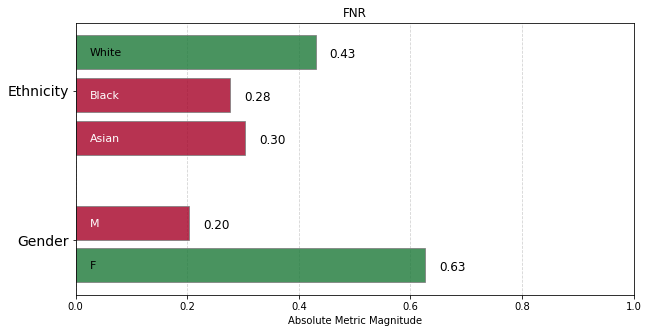

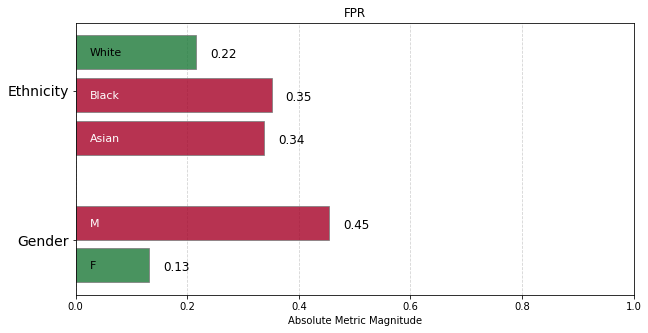

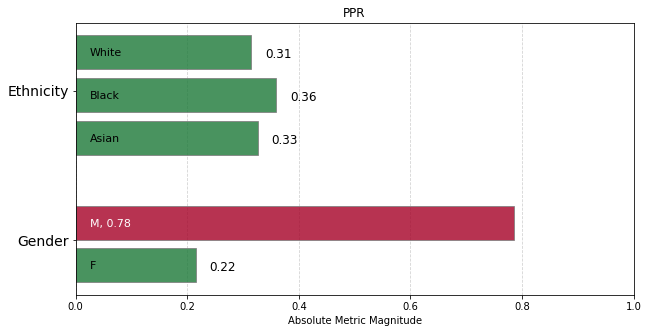

In [19]:
df_aequitas = pd.concat([X_test[['Gender', 'Ethnicity']],
                         y_test,
                         pd.DataFrame(y_pred, index=X_test.index)],
                        axis=1, sort=False)
df_aequitas.rename(columns={'Target': 'label_value',
                            0: 'score'}, inplace=True)

df_aequitas[df_aequitas.columns.difference(['label_value', 'score'])] = df_aequitas[
    df_aequitas.columns.difference(['label_value', 'score'])].astype(str)

g = Group()
xtab, _ = g.get_crosstabs(df_aequitas)
absolute_metrics = g.list_absolute_metrics(xtab)

b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df=df_aequitas,
                                        ref_groups_dict={'Gender': 'F', 'Ethnicity': 'White'}, alpha=0.05,
                                        mask_significance=True)
f = Fairness()
fdf = f.get_group_value_fairness(bdf)
aqp = Plot()

aqp.plot_fairness_group(fdf, group_metric='fnr')
plt.title('FNR')
aqp.plot_fairness_group(fdf, group_metric='fpr')
plt.title('FPR')
aqp.plot_fairness_group(fdf, group_metric='ppr')
plt.title('PPR')

How to interpret these numbers? First look at the following definitions:
- False Negative: the model predicted the candidate was not contacted by the recruiter, while he/she was
- False Positive: the model predicted the candidate was contacted by the recruiter, while he/she was not

Thus, when a candidate was selected for an interview by a recruiter, our AI incorrectly recommended not selecting these candidates 63% of the cases when the candidate was a women. In contrast, our AI only ignored good male candidates 20% of the time.
The opposite holds true when candidates had NOT been invited for an interview but our AI incorrectly recommended the candidate should be invited for an interview. For the female students our AI incorrectly recommended 13% of female candidates to be invited for an interview when it shouldn't have, whilst it recommended inviting 45% of poor male candidates. This is very informative, as it reflects the errors we are making for each subgroup.
Apparently, the algorithm predicts for a lot of women they are not suitable, while they actually were. On the other hand, the algorithm predicts for a large group of male candidates they are suitable, while they actually are not. This indicates the model learns to favor certain subgroups. <br>

The ppr and difference in means are more generalized fairness metrics, since they only consider how much the outcome differs between the protected classes. We see that there is 78% probability for a man to predict he is suitable for the job, while women only have 22%. 
The rate of this metric denotes Disparate Impact, a very common tool to measure unfairness in model predictions.

All confusion matrix metrics that can be used for fairness analysis are listed below. 

In [20]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,Gender,F,0.37,0.87,0.09,0.73,0.13,0.63,0.91,0.27,0.22,0.16,0.12
1,Gender,M,0.80,0.55,0.09,0.68,0.45,0.20,0.91,0.32,0.78,0.53,0.21
2,Ethnicity,Asian,0.70,0.66,0.08,0.72,0.34,0.30,0.92,0.28,0.33,0.40,0.16
3,Ethnicity,Black,0.72,0.65,0.08,0.69,0.35,0.28,0.92,0.31,0.36,0.42,0.18
4,Ethnicity,White,0.57,0.78,0.10,0.66,0.22,0.43,0.90,0.34,0.31,0.27,0.16


These numbers can be used to calculate the parities. A parity is simply the ratio of two metrics within the confusion matrix. As can be seen in the following chunk of code, the False Negative Ratio Parity is around 3.15. This indicates that we are 3.15 times more likely to have a false negative for a female candidate than for a male candidate. Remember a false negative in this case means we predicted the candidate not to be contacted by the recruiter, while he/she actually was invited for an interview. Apparently, the model is much more likely to make mistakes for suitable women than for suitable men. 
Similarly, our model is 3.4 times more likely to predict  male compared to female candidates to be invited for an interview when they were not.
In general, the Disparate Impact tells us we are 3 times more likely to say a candidate is selected when facing a male candidate than if she were a woman.

As a rule of thumb we can say there is a bias among your protected classes if the value of the parity goes below 0.5 or above 1.5. Based on this, we can definitely confirm we are having a discriminatory model here.

In [21]:
fnr_f = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)['fnr'][3]
fnr_m = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)['fnr'][4]
print("False negative Ratio Parity:", round(fnr_f/fnr_m,3))

fpr_f = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)['fpr'][3]
fpr_m = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)['fpr'][4]
print("False positive Ratio Parity:", round(fpr_m/fpr_f,3))

ppr_f = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)['ppr'][3]
ppr_m = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)['ppr'][4]
print("Disparate impact:", round(ppr_m/ppr_f,3))

False negative Ratio Parity: 0.651
False positive Ratio Parity: 0.629
Disparate impact: 0.861


##### Mitigating Unfairness

To calculate the difference in means we are using a different package (Aif360). This AI Fairness toolkit contains techniques developed by the research community to help detect and mitigate bias. In this case we use the difference in means to reweigh the data. This won't change the training data at all. Rather, it gives every training row a weight, such that the mean difference in outcomes is zero. In this case this boils down to:
- Examples of men who were contacted will be downweighted
- Examples of men who were not contacted will be upweighted
- Examples of women who were contacted are upweighted
- Examples of women who were not contacted will be downweighted

In [22]:
from aif360.datasets import BinaryLabelDataset
df_aif  = BinaryLabelDataset(df=pd.concat((X_train_logit, y_train_logit), axis = 1),
                                  label_names=['Target'],
                                  protected_attribute_names=['Gender_F'],
                                  favorable_label=1,
                                  unfavorable_label=0)

privileged_groups = [{'Gender_F': 0}]
unprivileged_groups = [{'Gender_F': 1}]

metric_orig_train = BinaryLabelDatasetMetric(df_aif, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

Difference in mean outcomes between unprivileged and privileged groups = -0.110713


In [23]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

After reweighing we can call the fit and transform methods to perform the transformation, producing a newly transformed training dataset. We can also extract the weights and compare it with the outcome to validate whether the weighing is succeeded. We see that male students are getting downweighted (+/- 0.77) when they were a good candidate and upweighted when they were a poor candidate, whilst female candidates are upweighted (+/- 1.47) when they were good candidates and downweighted when they were poor candidates.

In [24]:
dataset_transf_train = RW.fit_transform(df_aif)
weights_gender = dataset_transf_train.instance_weights

pd.DataFrame({'Female': X_train_logit['Gender_F'],
              'Target': y_train,
              'weight': weights_gender}).head(100)

,Female,Target,weight
725,1,0,0.934701
218,1,0,0.934701
620,0,1,0.770701
493,1,0,0.934701
1447,0,0,1.069591
...,...,...,...
1352,1,1,1.469413
268,1,0,0.934701
193,1,0,0.934701
488,0,0,1.069591


Now, we make new predictions.

In [25]:
logreg = LogisticRegression(class_weight = weights)
logreg.fit(X_train_logit, y_train_logit,
          sample_weight = weights_gender)
y_pred = logreg.predict(X_test_logit)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_logit, y_test_logit)))

Accuracy of logistic regression classifier on test set: 0.69


C:\Users\Jasper Rouschop\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


##### Reevaluating Unfairness

When the new predictions are obtained, we use the Aequitas toolkit again to audit the model for discrimination and bias. Again, there are two variables that reflect protected classes; Gender and Ethnicity. Let's look at the mistakes we are making now to see whether we succeeded to mitigate the unfairness. In order to do so, we will look how the fnr, fpr and ppr have changed when the data was reweighted setting the difference in means equal to zero.

Let's compare some metrics among the protected classes.

model_id, score_thresholds 1 {'rank_abs': [426]}
get_disparity_predefined_group()


Text(0.5, 1.0, 'PPR')

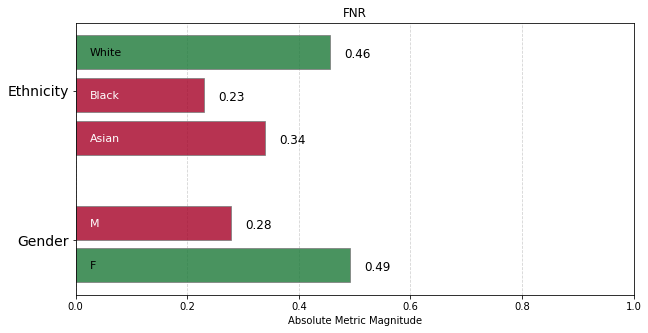

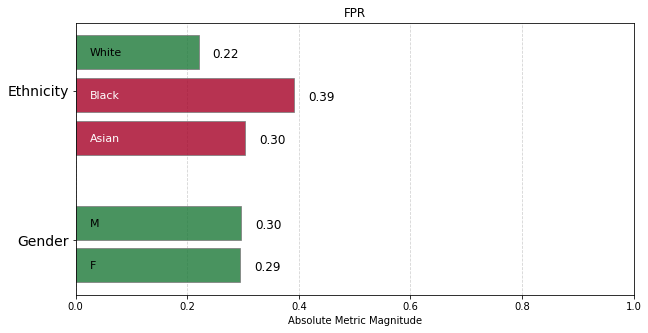

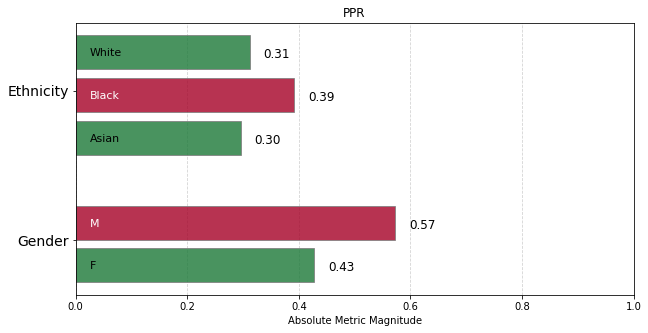

In [26]:
df_aequitas = pd.concat([X_test[['Gender', 'Ethnicity']], 
                         y_test,
                         pd.DataFrame(y_pred, index = X_test.index)],
                        axis = 1, sort = False)
df_aequitas.rename(columns = {'Target': 'label_value',
                              0: 'score'}, inplace = True)

df_aequitas[df_aequitas.columns.difference(['label_value', 'score'])] = df_aequitas[df_aequitas.columns.difference(['label_value', 'score'])].astype(str)

g = Group()
xtab, _ = g.get_crosstabs(df_aequitas)
absolute_metrics = g.list_absolute_metrics(xtab)

b= Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df = df_aequitas, ref_groups_dict = {'Gender':'F', 'Ethnicity':'White'}, alpha = 0.05, mask_significance = True)
f = Fairness()
fdf = f.get_group_value_fairness(bdf)
aqp = Plot()

aqp.plot_fairness_group(fdf, group_metric='fnr')
plt.title('FNR')
aqp.plot_fairness_group(fdf, group_metric='fpr')
plt.title('FPR')
aqp.plot_fairness_group(fdf, group_metric='ppr')
plt.title('PPR')

According to the FNR, 49% of the female candidates that were not selected, were actually found suitable candidates. Still not that good, but it is better than the earlier found 60%. On the other hand, we pay the price by making more mistakes with male candidates. After reweighing, 28% of the suitable mnale candidates were rejected, while this was only 20%.
Nevertheless, the errors we are making on both protected subgroups has somewhat converged, making the model less unfair. Considering this metric we managed to mitigate the bias, but not fully diminish it. <br>
On the other hand, when the  fpr is considered, we see that we managed to create a fair model. Before reweighing there was 45% probability our AI would incorrectly recommend a male candidate who in fact was not invited.
For women this probabillity was 15%. After reweighing the data, these probabilities have converged to 30% for men and 29% for women.

All confusion matrix metrics are listed below.

In [27]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,Gender,F,0.51,0.71,0.09,0.81,0.29,0.49,0.91,0.19,0.43,0.32,0.12
1,Gender,M,0.72,0.70,0.10,0.61,0.30,0.28,0.90,0.39,0.57,0.39,0.21
2,Ethnicity,Asian,0.66,0.70,0.09,0.71,0.30,0.34,0.91,0.29,0.30,0.36,0.16
3,Ethnicity,Black,0.77,0.61,0.08,0.70,0.39,0.23,0.92,0.30,0.39,0.46,0.18
4,Ethnicity,White,0.54,0.78,0.10,0.68,0.22,0.46,0.90,0.32,0.31,0.27,0.16


The numbers from this table can be used to calculate the parities.

In [28]:
fnr_f = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)['fnr'][3]
fnr_m = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)['fnr'][4]
print("False negative Ratio Parity:", round(fnr_f/fnr_m,3))

fpr_f = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)['fpr'][3]
fpr_m = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)['fpr'][4]
print("False positive Ratio Parity:", round(fpr_m/fpr_f,3))

ppr_f = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)['ppr'][3]
ppr_m = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)['ppr'][4]
print("Disparate impact:", round(ppr_m/ppr_f,3))

False negative Ratio Parity: 0.5
False positive Ratio Parity: 0.564
Disparate impact: 0.795


Considering the rule of thumb a parity should be between 0.5 and 1.5, we can say reweighing made this model reasonably fair. The disparate impact still shows that men are somewhat favored over women, but the difference is not much reduced. Based on the false negative ratio parity we can say that we managed to mitigate the bias, but the model is still unfair. When the candidate was actually targeted by the recruiters, we still make more mistakes with women than with men. Although the unfairness has somewhat mitigated, our AI-driven recruitment bot is still less likely to invite suitable female candidates than suitable male candidates.

Luckily at VIQTOR DAVIS we can use many other methods to further mitigate unfairness and work towards responsible AI solutions.

### Conclusion

Machine learning is an extremely powerful tool. And with great power comes great responsibility. This means that we have a responsibility to create algorithms that are fair. Machine learning is, by nature, based on the history of our societies.
And we cannot expect machine learning to solve all our human prejudices and biased datasets. If we provide biased input, our algorithms will adopt this behavior and provide unfair output. However, beyond such label- or sample bias, unfairness may unwittingly and unwillingly creep into AI models as we show in our case study here. We therefore need to actively assess and mitigate the unfairness of our models. 
Especially when these (biased) models are involved in important decision-making processes for certain protected classes (like gender, ethnicity or religion).

In this case study we applied reweighing, a preprocessing algorithm to mitigate model unfairness. 
There is no such thing as the "best" bias mitigation strategy and we usually implement multiple. As long as you keep evaluating your (multiple) fairness metrics, feel free to try different strategies!
